### Resource

- [google drive](https://drive.google.com/drive/u/1/folders/1N15PTA1y0ou5YyPDUN-MdlTGPXq3Rxhc)
- [iowa liquor dataset](https://console.cloud.google.com/bigquery?authuser=1&invt=AbtrQg&project=solid-dominion-452916-p4&supportedpurview=project&ws=!1m5!1m4!4m3!1sbigquery-public-data!2siowa_liquor_sales!3ssales)
- [iowa county population](https://data.iowa.gov/Community-Demographics/County-Population-in-Iowa-by-Year/qtnr-zsrc/about_data)
- [iowa city population](https://data.iowa.gov/Community-Demographics/Iowa-Population-by-City-ACS-5-Year-Estimates-/26ad-icvy/about_data)
- [iowa income](https://data.iowa.gov/Economic-Statistics/Annual-Personal-Income-for-State-of-Iowa-by-County/st2k-2ti2/about_data)

### Packages

In [1]:
import pandas_gbq
from google.oauth2 import service_account
import pandas as pd
import plotnine as p9
from sodapy import Socrata

# 1. Load Data

In [91]:
SERVICE_ACCOUNT_FILE = 'secret/service_account_key.json'
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)

sql = """
SELECT 
    date,
    store_name,
    city,
    county,
    item_description,
    state_bottle_cost,
    state_bottle_retail,
    bottles_sold,
    sale_dollars,
    volume_sold_liters
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date >= '2024-01-01' AND date < '2025-01-01'
"""

df_google_cloud = pandas_gbq.read_gbq(sql, credentials=credentials)

Downloading:   3%|▎         |
Downloading: 100%|██████████|


In [92]:
df_google = df_google_cloud.copy()
df_google['gross_profit'] = (
    (df_google['state_bottle_retail'] - df_google['state_bottle_cost']) * df_google['bottles_sold']
)
df_google.rename(columns={
    'store_name': 'store',
    'item_description': 'item',
    'bottles_sold': 'bottles',
}, inplace=True)
df_google.columns = df_google.columns.str.lower()
df_google['store'] = df_google['store'].str.lower()
df_google['city'] = df_google['city'].str.lower()
df_google['county'] = df_google['county'].str.lower()
df_google['item'] = df_google['item'].str.lower()
df_google.head()

,date,store,city,county,item,state_bottle_cost,state_bottle_retail,bottles,sale_dollars,volume_sold_liters,gross_profit
0,2024-05-06,riverside #4 / bettendorf,bettendorf,scott,parrot bay variety pack mini,4.80,7.20,1,7.20,0.05,2.4
1,2024-11-03,tequila's liquor store,des moines,polk,new amsterdam pink whitney bucket mini,55.98,83.97,1,83.97,0.05,27.99
2,2024-10-23,hy-vee food store / cherokee,cherokee,cherokee,99 toasted flavorites mini,52.32,78.48,1,78.48,0.05,26.16
3,2024-07-01,fareway stores #963 / cedar rapids,cedar rapids,linn,crown royal regal apple mini,5.91,8.87,1,8.87,0.05,2.96
4,2024-07-06,casey's general store #3035 / atlant,atlantic,cass,crown royal regal apple mini,5.91,8.87,1,8.87,0.05,2.96


In [74]:
print("The earliest date:", df_google['date'].min())
print("The latest date:", df_google['date'].max())
print("# of stores:", df_google['store'].nunique())
print("# of cities:", df_google['city'].nunique())
print("# of counties:", df_google['county'].nunique())

The earliest date: 2024-01-01
The latest date: 2024-12-31
# of stores: 2151
# of cities: 471
# of counties: 99


## 1-1. Liquor Stores

In [95]:
df_store = (
    df_google
    .groupby(['store', 'city', 'county', 'date', 'item'])
    .agg({
        'bottles': 'sum',
        'gross_profit': 'sum',
    })
    .reset_index()
)
df_store

,store,city,county,date,item,bottles,gross_profit
0,'da booze barn / west bend,west bend,palo alto,2024-01-04,99 fruits mini,1,25.8
1,'da booze barn / west bend,west bend,palo alto,2024-01-04,barton vodka,6,21.18
2,'da booze barn / west bend,west bend,palo alto,2024-01-04,cabo wabo blanco,6,63.0
3,'da booze barn / west bend,west bend,palo alto,2024-01-04,canadian ltd whisky,6,30.0
4,'da booze barn / west bend,west bend,palo alto,2024-01-04,captain morgan original spiced mini,1,2.4
...,...,...,...,...,...,...,...
2349070,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,canadian ltd whisky,24,27.12
2349071,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,crown royal,12,105.0
2349072,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,fireball cinnamon whiskey,102,298.08
2349073,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,fireball cinnamon whiskey mini dispenser,1,12.9


In [115]:
print('Summary of bottles:\n', df_store['bottles'].describe())
print()
print('Summary of gross profit:\n', df_store['gross_profit'].describe())

Summary of bottles:
 count    2349075.0
mean     13.360109
std      38.253847
min         -456.0
25%            3.0
50%            6.0
75%           12.0
max        13230.0
Name: bottles, dtype: Float64

Summary of gross profit:
 count     2349075.0
mean      63.473408
std      225.471208
min         -1470.0
25%            18.0
50%            33.0
75%           62.04
max         87273.0
Name: gross_profit, dtype: Float64


## 1-2. Population

In [116]:
df_pop_city = pd.read_csv('https://mydata.iowa.gov/resource/26ad-icvy.csv')
df_pop_city.columns = df_pop_city.columns.str.lower()
df_pop_city.rename(columns={
    'name': 'city',
    'value': 'pop_city',
    'data_collection_period': 'year'
}, inplace=True)
df_pop_city['city'] = df_pop_city['city'].str[:-6]
df_pop_city['city'] = df_pop_city['city'].str.lower()
df_pop_city['year'] = df_pop_city['year'].str[-4:]
df_pop_city = df_pop_city[['city', 'year', 'pop_city']]
df_pop_city = df_pop_city[df_pop_city['year']=='2022']
df_pop_city['pop_city'] = df_pop_city['pop_city'].astype(int)
df_pop_city = df_pop_city[['city', 'pop_city']]
df_pop_city

,city,pop_city
0,ackley,1699
1,ackworth,106
2,adair,828
3,adel,6090
4,afton,1105
...,...,...
936,yale,316
937,yetter,16
938,yorktown,35
939,zearing,655


In [117]:
df_pop_county = pd.read_csv('data/iowa_population_county.csv')
df_pop_county.columns = df_pop_county.columns.str.lower()
df_pop_county.rename(columns={
    'population': 'pop_county'
}, inplace=True)
df_pop_county['year'] = df_pop_county['year'].str[-4:]
df_pop_county['county'] = df_pop_county['county'].str[:-7]
df_pop_county['county'] = df_pop_county['county'].str.lower()
df_pop_county = df_pop_county[['county', 'year', 'pop_county']]
df_pop_county = df_pop_county[df_pop_county['year']=='2023']
df_pop_county

,county,year,pop_county
35,poweshiek,2023,18453
134,jefferson,2023,15440
158,chickasaw,2023,11658
242,mitchell,2023,10518
245,wright,2023,12656
...,...,...,...
3191,webster,2023,36485
3255,plymouth,2023,25722
3288,fayette,2023,19210
3328,jasper,2023,37919


## 1-3. Income

In [55]:
client = Socrata("data.iowa.gov", None)
df_list = []
offset = 0

while True:
    results = client.get("st2k-2ti2",
                         limit = 1000,
                         offset = offset)
    offset = offset + 1000
    df_list.extend(results)

    if len(results) < 1000:
        break

df_income = pd.DataFrame.from_records(df_list)

df_income['date'] = df_income['date'].str[:4]
df_income = df_income[
    (df_income['date']=='2022') & 
    (df_income['variable']=='Per capita personal income')
    ]
df_income.rename(columns={
    'name': 'county',
    'date': 'year',
    'value': 'annual_income',
}, inplace=True)
df_income['county'] = df_income['county'].str.lower()
df_income = df_income[['county', 'year', 'annual_income']]
df_income['annual_income'] = pd.to_numeric(df_income['annual_income'], errors='coerce')
df_income

,county,year,annual_income
51,adair,2022,67668
103,adams,2022,67657
155,allamakee,2022,55015
207,appanoose,2022,47779
259,audubon,2022,69105
...,...,...,...
4939,winnebago,2022,55013
4991,winneshiek,2022,61042
5043,woodbury,2022,51029
5095,worth,2022,55418


## 1-4. Data Frame

In [122]:
df_county = pd.merge(df_pop_county, df_income, on='county', how='left')
df_county = df_county[['county', 'pop_county', 'annual_income']]
df = pd.merge(df_store, df_pop_city, on='city', how='left')
df = pd.merge(df, df_county, on='county', how='left')
df

,store,city,county,date,item,bottles,gross_profit,pop_city,pop_county,annual_income
0,'da booze barn / west bend,west bend,palo alto,2024-01-04,99 fruits mini,1,25.8,936.0,8810,65080
1,'da booze barn / west bend,west bend,palo alto,2024-01-04,barton vodka,6,21.18,936.0,8810,65080
2,'da booze barn / west bend,west bend,palo alto,2024-01-04,cabo wabo blanco,6,63.0,936.0,8810,65080
3,'da booze barn / west bend,west bend,palo alto,2024-01-04,canadian ltd whisky,6,30.0,936.0,8810,65080
4,'da booze barn / west bend,west bend,palo alto,2024-01-04,captain morgan original spiced mini,1,2.4,936.0,8810,65080
...,...,...,...,...,...,...,...,...,...,...
2349070,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,canadian ltd whisky,24,27.12,690.0,14396,66517
2349071,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,crown royal,12,105.0,690.0,14396,66517
2349072,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,fireball cinnamon whiskey,102,298.08,690.0,14396,66517
2349073,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,fireball cinnamon whiskey mini dispenser,1,12.9,690.0,14396,66517


# 2. Exploere Data

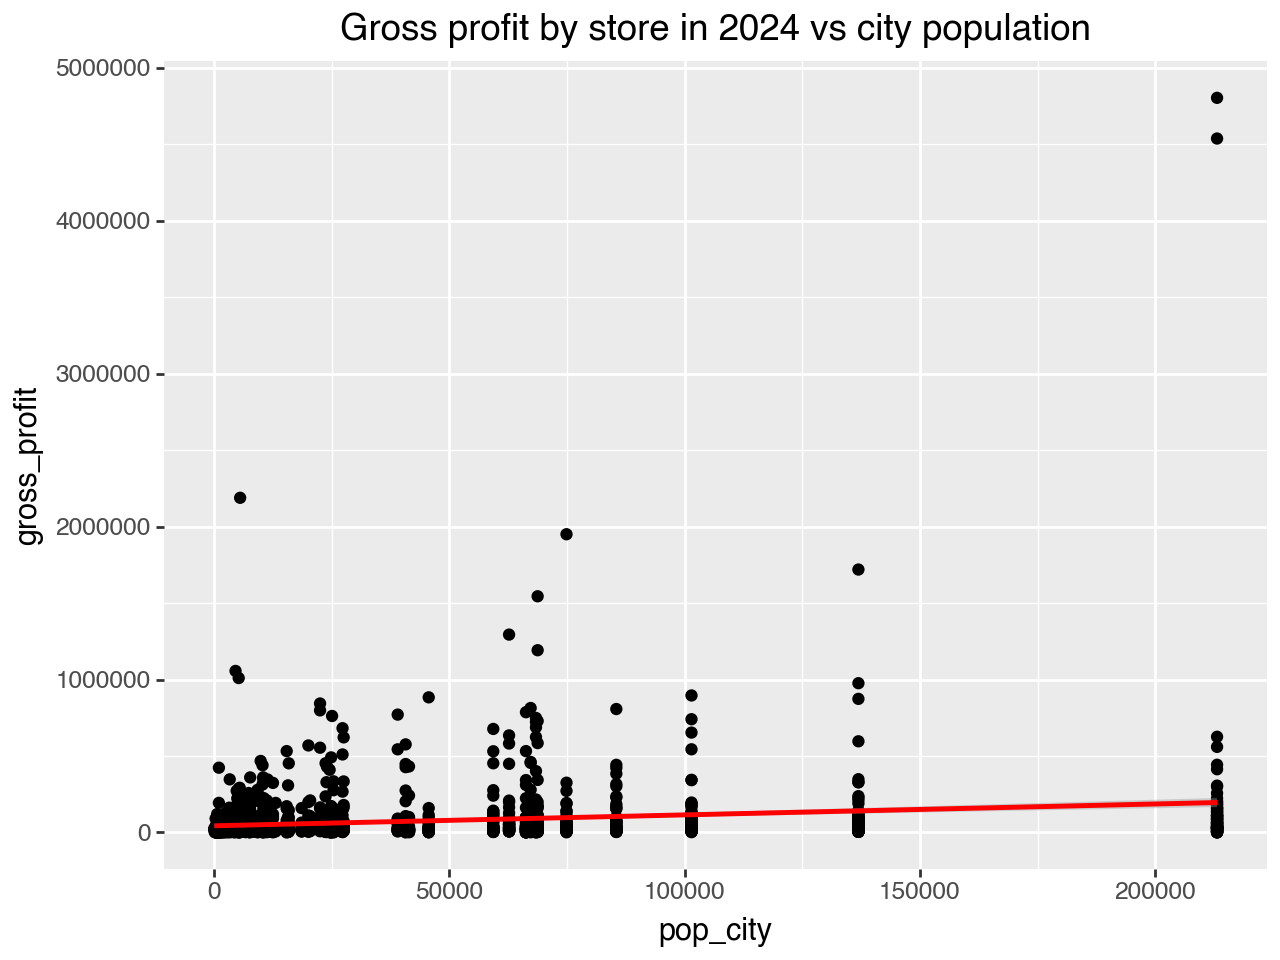

In [83]:
df_store_pop = df.groupby(['store', 'pop_city'])['gross_profit'].sum().reset_index(name='gross_profit')
plot = (
    p9.ggplot(df_store_pop, p9.aes(x='pop_city', y='gross_profit')) +
    p9.geom_point() +
    p9.geom_smooth(color='red') +
    p9.labs(title='Gross profit by store in 2024 vs city population') 
)
plot

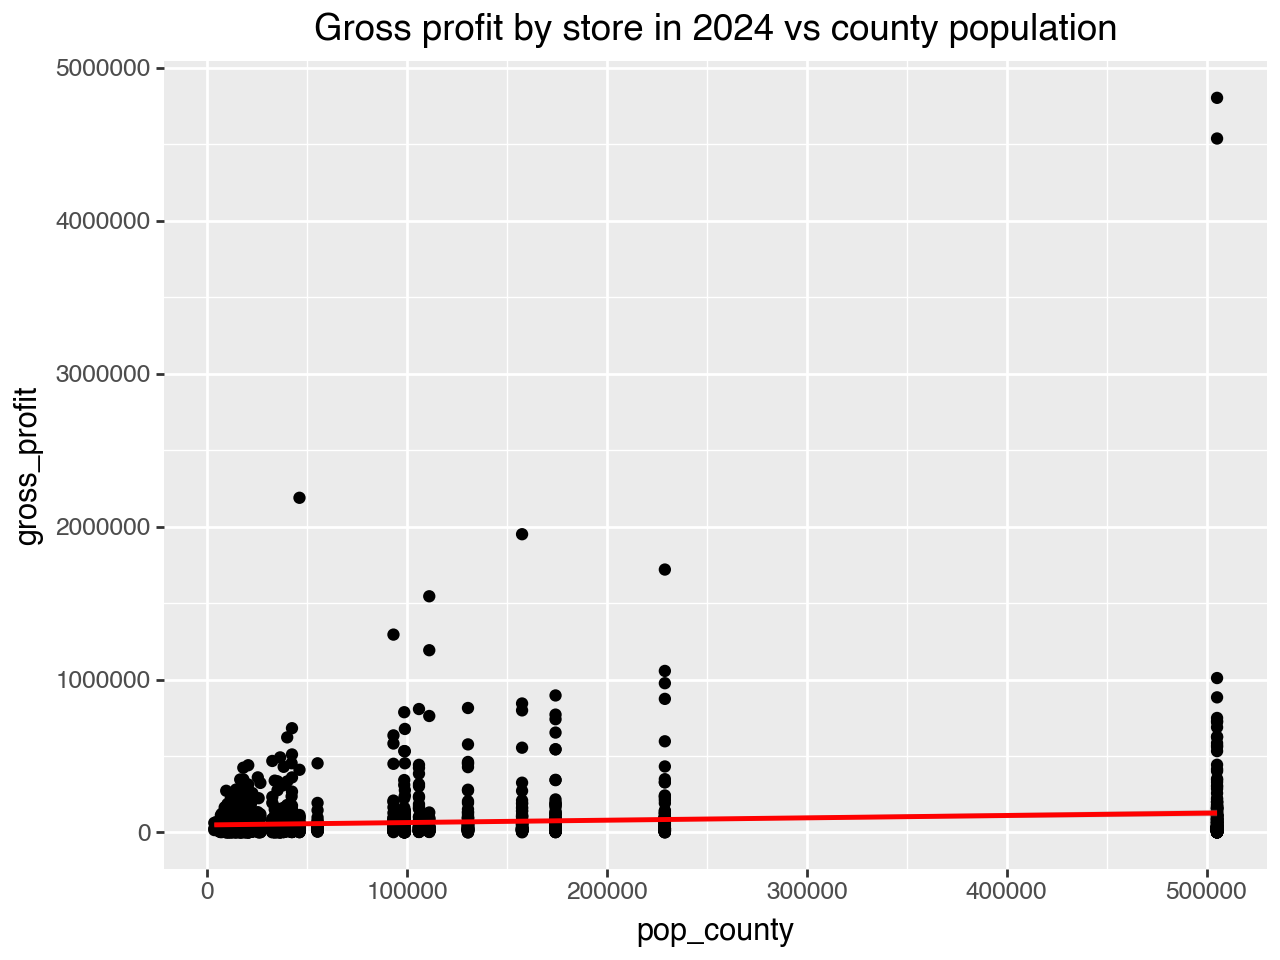

In [84]:
df_store_pop_county = df.groupby(['store', 'pop_county'])['gross_profit'].sum().reset_index(name='gross_profit')
plot = (
    p9.ggplot(df_store_pop_county, p9.aes(x='pop_county', y='gross_profit')) +
    p9.geom_point() +
    p9.geom_smooth(color='red') +
    p9.labs(title='Gross profit by store in 2024 vs county population') 
)
plot

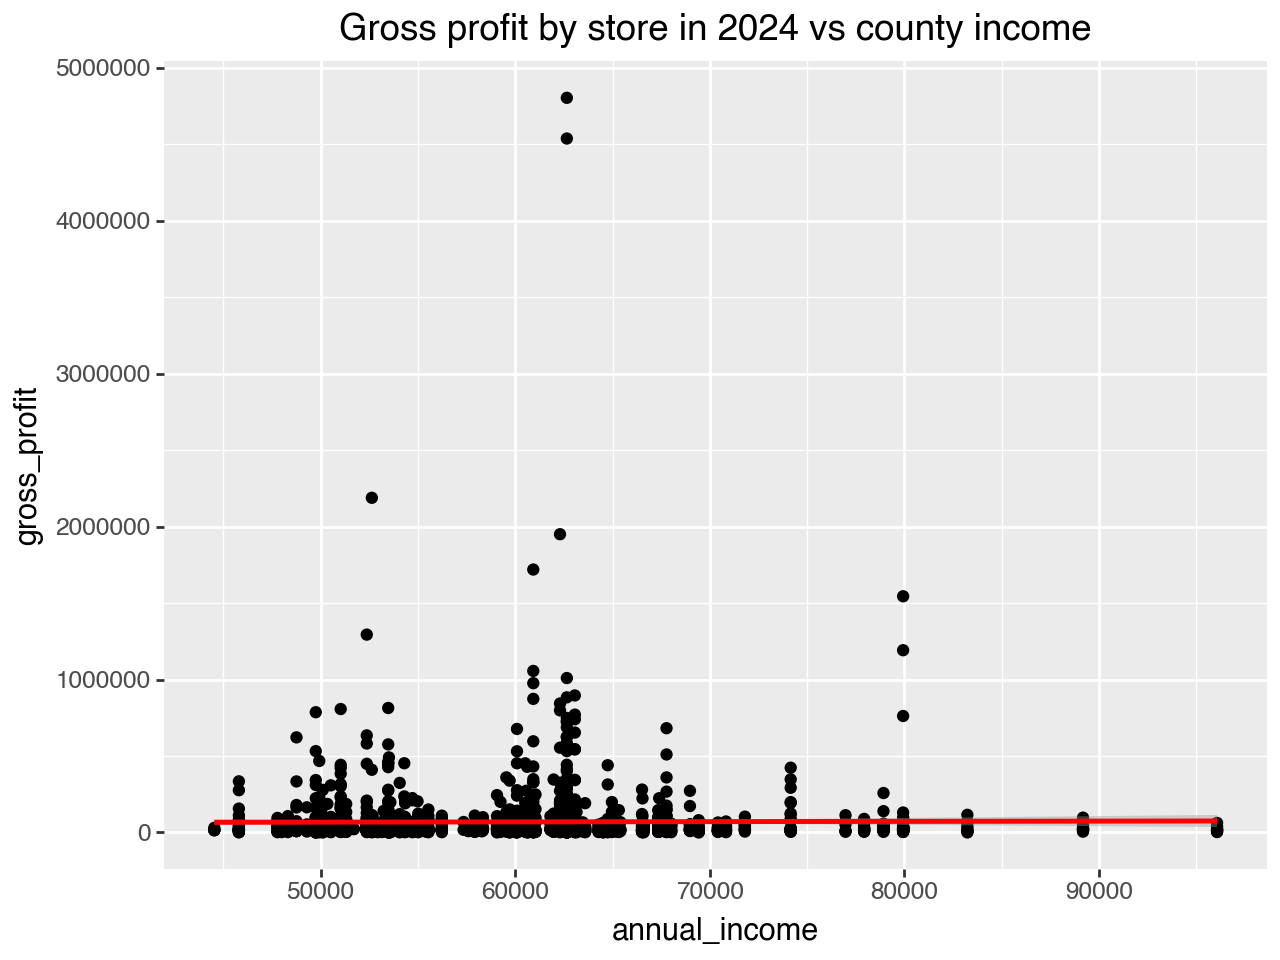

In [126]:
df_store_income = df.groupby(['store', 'annual_income'])['gross_profit'].sum().reset_index(name='gross_profit')
plot = (
    p9.ggplot(df_store_income, p9.aes(x='annual_income', y='gross_profit')) +
    p9.geom_point() +
    p9.geom_smooth(color='red') +
    p9.labs(title='Gross profit by store in 2024 vs county income') 
)
plot

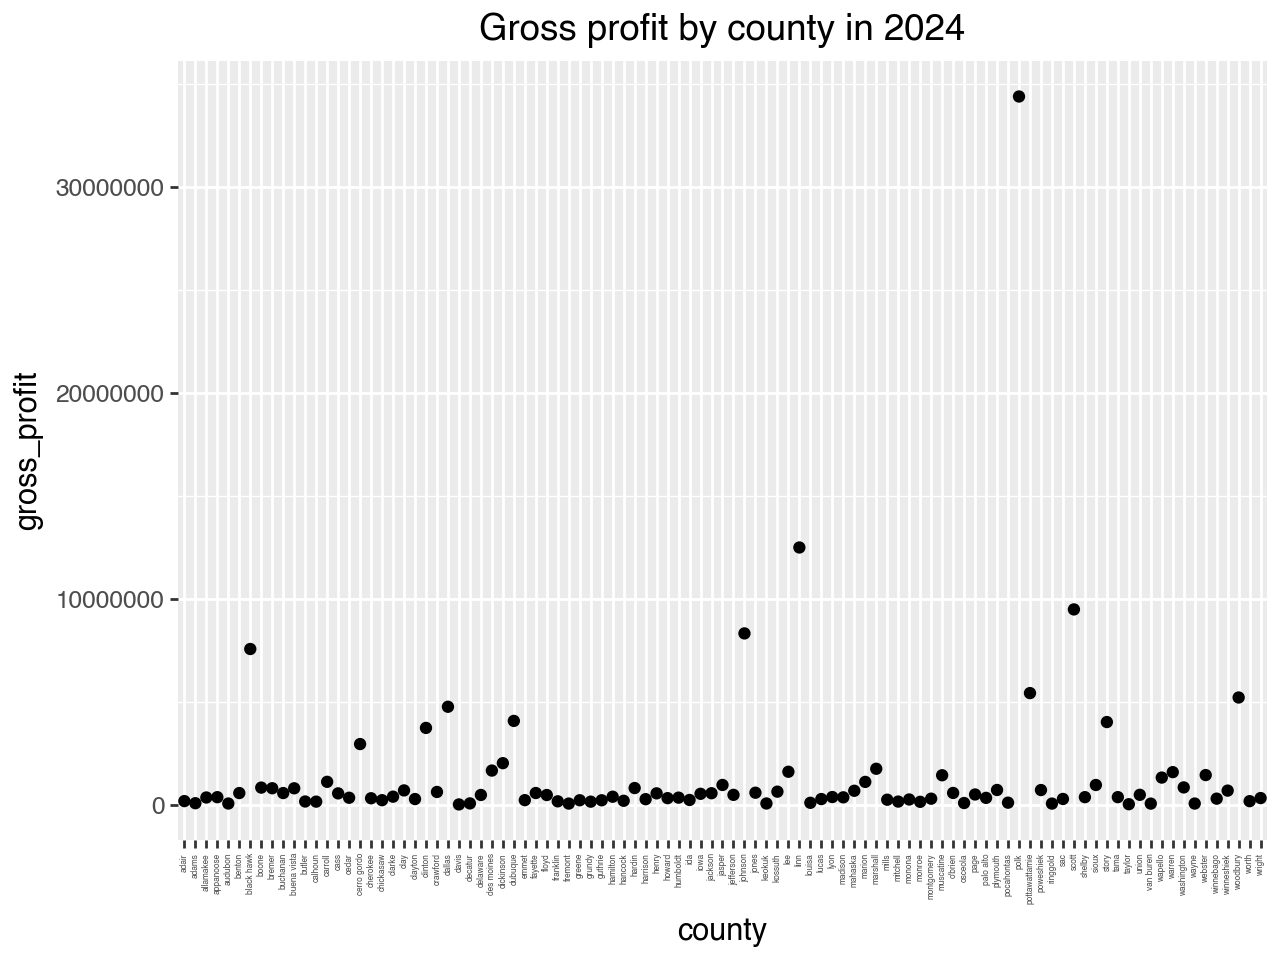

In [127]:
df_county_profit = df.groupby(['county'])['gross_profit'].sum().reset_index(name='gross_profit')
plot = (
    p9.ggplot(df_county_profit, p9.aes(x='county', y='gross_profit')) +
    p9.geom_point() +
    p9.labs(title='Gross profit by county in 2024') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=3))
)
plot